In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import f1_score

import warnings

warnings.filterwarnings("ignore")


# Métodos de Classificação II

Vamos avançar nossos estudos sobre métodos de classificação analisando dois novos algoritmos (o *Perceptron de Múltiplas Camadas* e os *Modelos de Ensemble*). Além disso teremos o primeiro contato com os conceitos de *underfitting* e *overfitting*, e como esses conceitos se relacionam com a **complexidade** dos modelos de ML.

Primeiro, vamos carregar nosso dataset de exemplo:

In [2]:
tb_cov = pd.read_parquet("data/covtype.parquet")
tb_cov.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,target,Wilderness_Area,Soil_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,Aspen,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,Aspen,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,Lodgepole Pine,Rawah Wilderness Area,"montane, igneous and metamorphic, 44"
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,Lodgepole Pine,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 46"
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,Aspen,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"


In [5]:
tb_cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  target                              581012 non-null  object 
 11  Wilderness_Area           

## Conjunto de Dados de Cobertura Florestal dos EUA

Este conjunto de dados contém informações sobre a cobertura florestal de diferentes lugares dos Estados Unidos. Além da variável target, que é o tipo de árvore predominante na área, também temos informações sobre a região, como:

- Altitude
- Inclinação do terreno
- Distância até a água mais próxima

Essas informações foram obtidas a partir do processamento de imagens de satélite.

### Análise da Variável Target

A variável target é o tipo de árvore predominante na área:


In [6]:
tb_cov["target"].value_counts()

target
Lodgepole Pine       283301
Spruce/Fir           211840
Ponderosa Pine        35754
Krummholz             20510
Douglas-fir           17367
Aspen                  9493
Cottonwood/Willow      2747
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

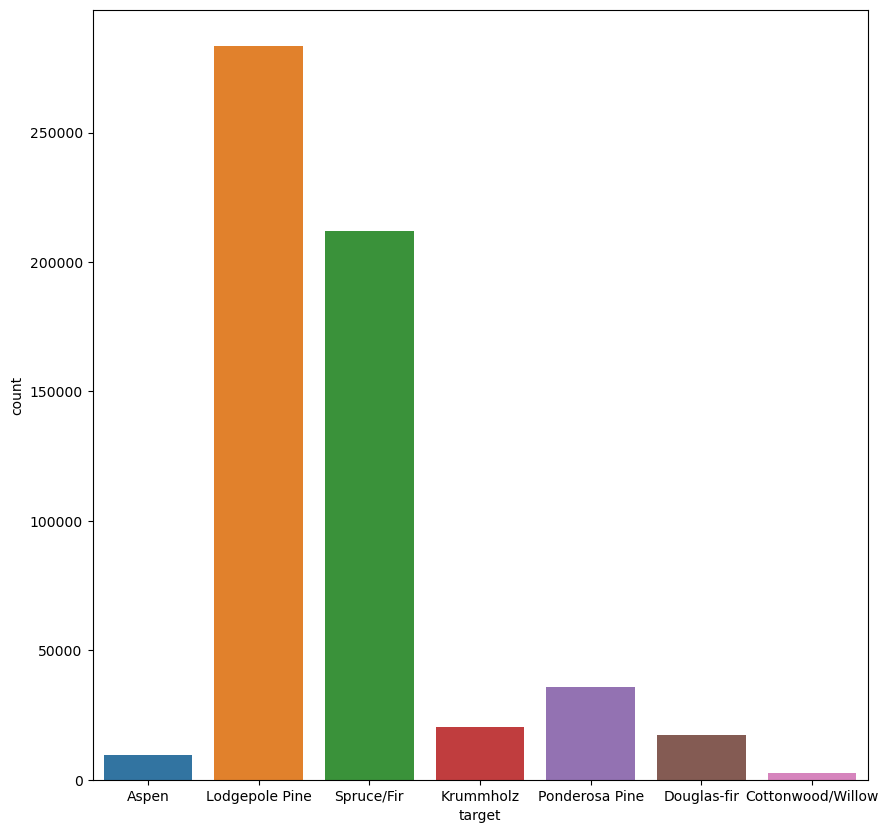

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.countplot(data=tb_cov, x="target")


Como podemos ver no gráfico acima, temos um total de 7 classes de árvores. A classe predominante é a segunda no gráfico, que corresponde à árvores do tipo *Lodgepole Pine*.

Esse tipo de fenômeno é comum em problemas de classificação (como no exemplo de fraudes em cartão de crédito): **nossas classe estão desbalanceadas**. Isso significa que temos muito mais exemplos de uma classe do que de outras. No caso de fraudes, temos muito mais transações legítimas do que fraudulentas. No caso de árvores, temos muito mais *Lodgepole Pine* e *Spruce/Fir* do que o resto.

O desbalanço de classes pode ser um problema para alguns algoritmos de classificação. Por exemplo, se tivermos um algoritmo que sempre chuta a classe mais frequente, ele terá uma acurácia de 50% no nosso dataset de árvores. Isso porque 50% das árvores são *Lodgepole Pine*. Mais adiante veremos como podemos tratar esse problema. Primeiro, vamos usar um `LabelEncoder` para converter nosso target de `strings` para números de forma estruturada:



In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder()
le.fit(tb_cov["target"])

LabelEncoder()

In [23]:
tb_cov["target"]

0                  Aspen
1                  Aspen
2         Lodgepole Pine
3         Lodgepole Pine
4                  Aspen
               ...      
581007    Ponderosa Pine
581008    Ponderosa Pine
581009    Ponderosa Pine
581010    Ponderosa Pine
581011    Ponderosa Pine
Name: target, Length: 581012, dtype: object

In [10]:
le.transform(tb_cov["target"])

array([0, 0, 4, ..., 5, 5, 5])

In [11]:
le.classes_

array(['Aspen', 'Cottonwood/Willow', 'Douglas-fir', 'Krummholz',
       'Lodgepole Pine', 'Ponderosa Pine', 'Spruce/Fir'], dtype=object)

A utilização de um `LabelEncoder` garante que as categorias sejam sempre ordenadas da mesma forma (a primeira classe é sempre 0, a segunda é sempre 1, etc).

### Análise dos Features

In [12]:
tb_cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  target                              581012 non-null  object 
 11  Wilderness_Area           

Temos ao todo 12 features contendo informações sobre a localização, o solo e o clima de cada área. Entre essas, 2 são categóricas e 10 são numéricas. Vamos focar nossa análise exploratória em dois eixos: avaliar a colinearidade e distribuição de nossos variáveis numéricas.

#### Colinearidade

Vamos analisar a colinearidade entre nossas variáveis numéricas. Para isso, vamos utilizar a matriz de correlação:

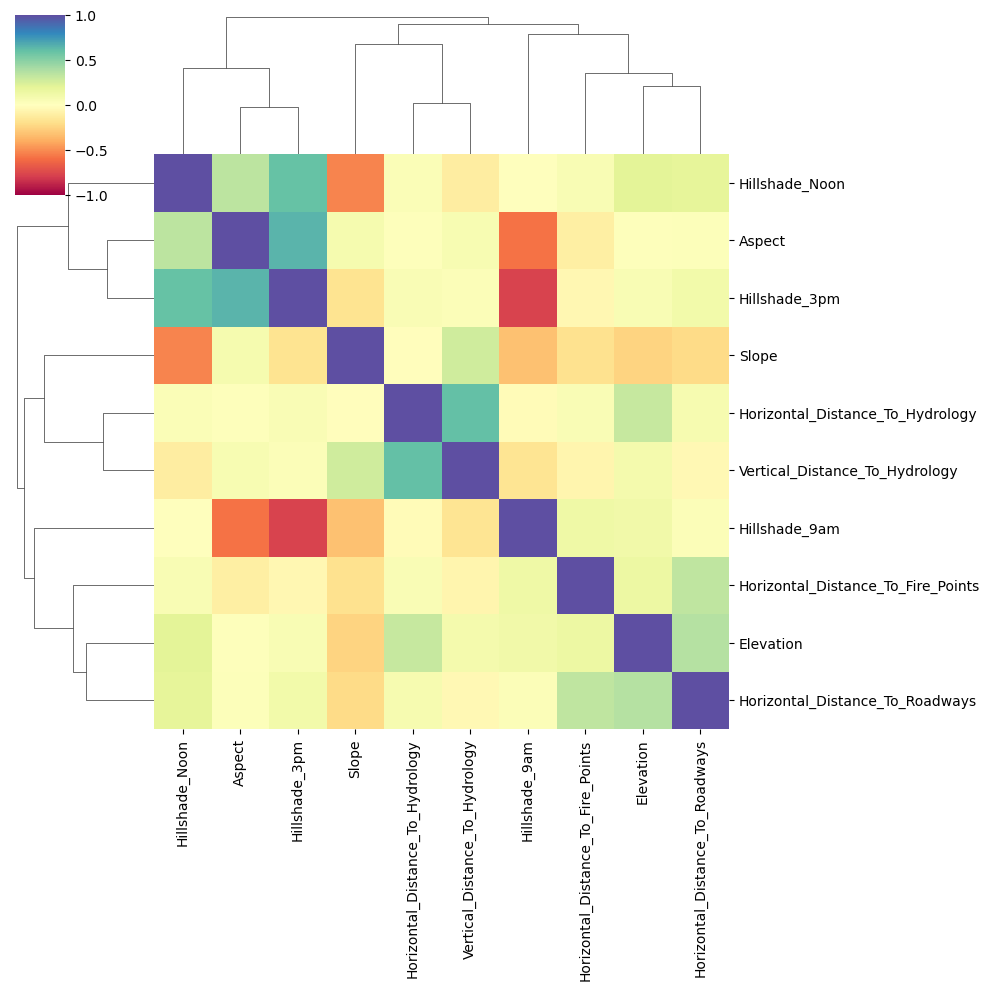

In [17]:
sns.clustermap(tb_cov.corr(numeric_only=True), vmin=-1, vmax=1, cmap="Spectral")


A função `sns.clustermap()` nos permite visualizar grupos de variáveis correlatas (diretamente ou indiretamente). Na sua avaliação, temos grupos de variáveis correlatas? Como podemos tratar essa colinearidade sem descartar variáveis?

#### Distribuição

Como vimos quando trabalhamos no problema dos diamantes, variáveis positivas com distribuição muito assimétrica podem ser transformadas para melhorar o desempenho de alguns algoritmos. Vamos avaliar a distribuição de nossas variáveis numéricas utilizando histogramas.

In [18]:
tb_melt = tb_cov.select_dtypes(include=np.number).melt()


In [20]:
tb_melt

,variable,value
0,Elevation,2596.0
1,Elevation,2590.0
2,Elevation,2804.0
3,Elevation,2785.0
4,Elevation,2595.0
...,...,...
5810115,Horizontal_Distance_To_Fire_Points,837.0
5810116,Horizontal_Distance_To_Fire_Points,845.0
5810117,Horizontal_Distance_To_Fire_Points,854.0
5810118,Horizontal_Distance_To_Fire_Points,864.0


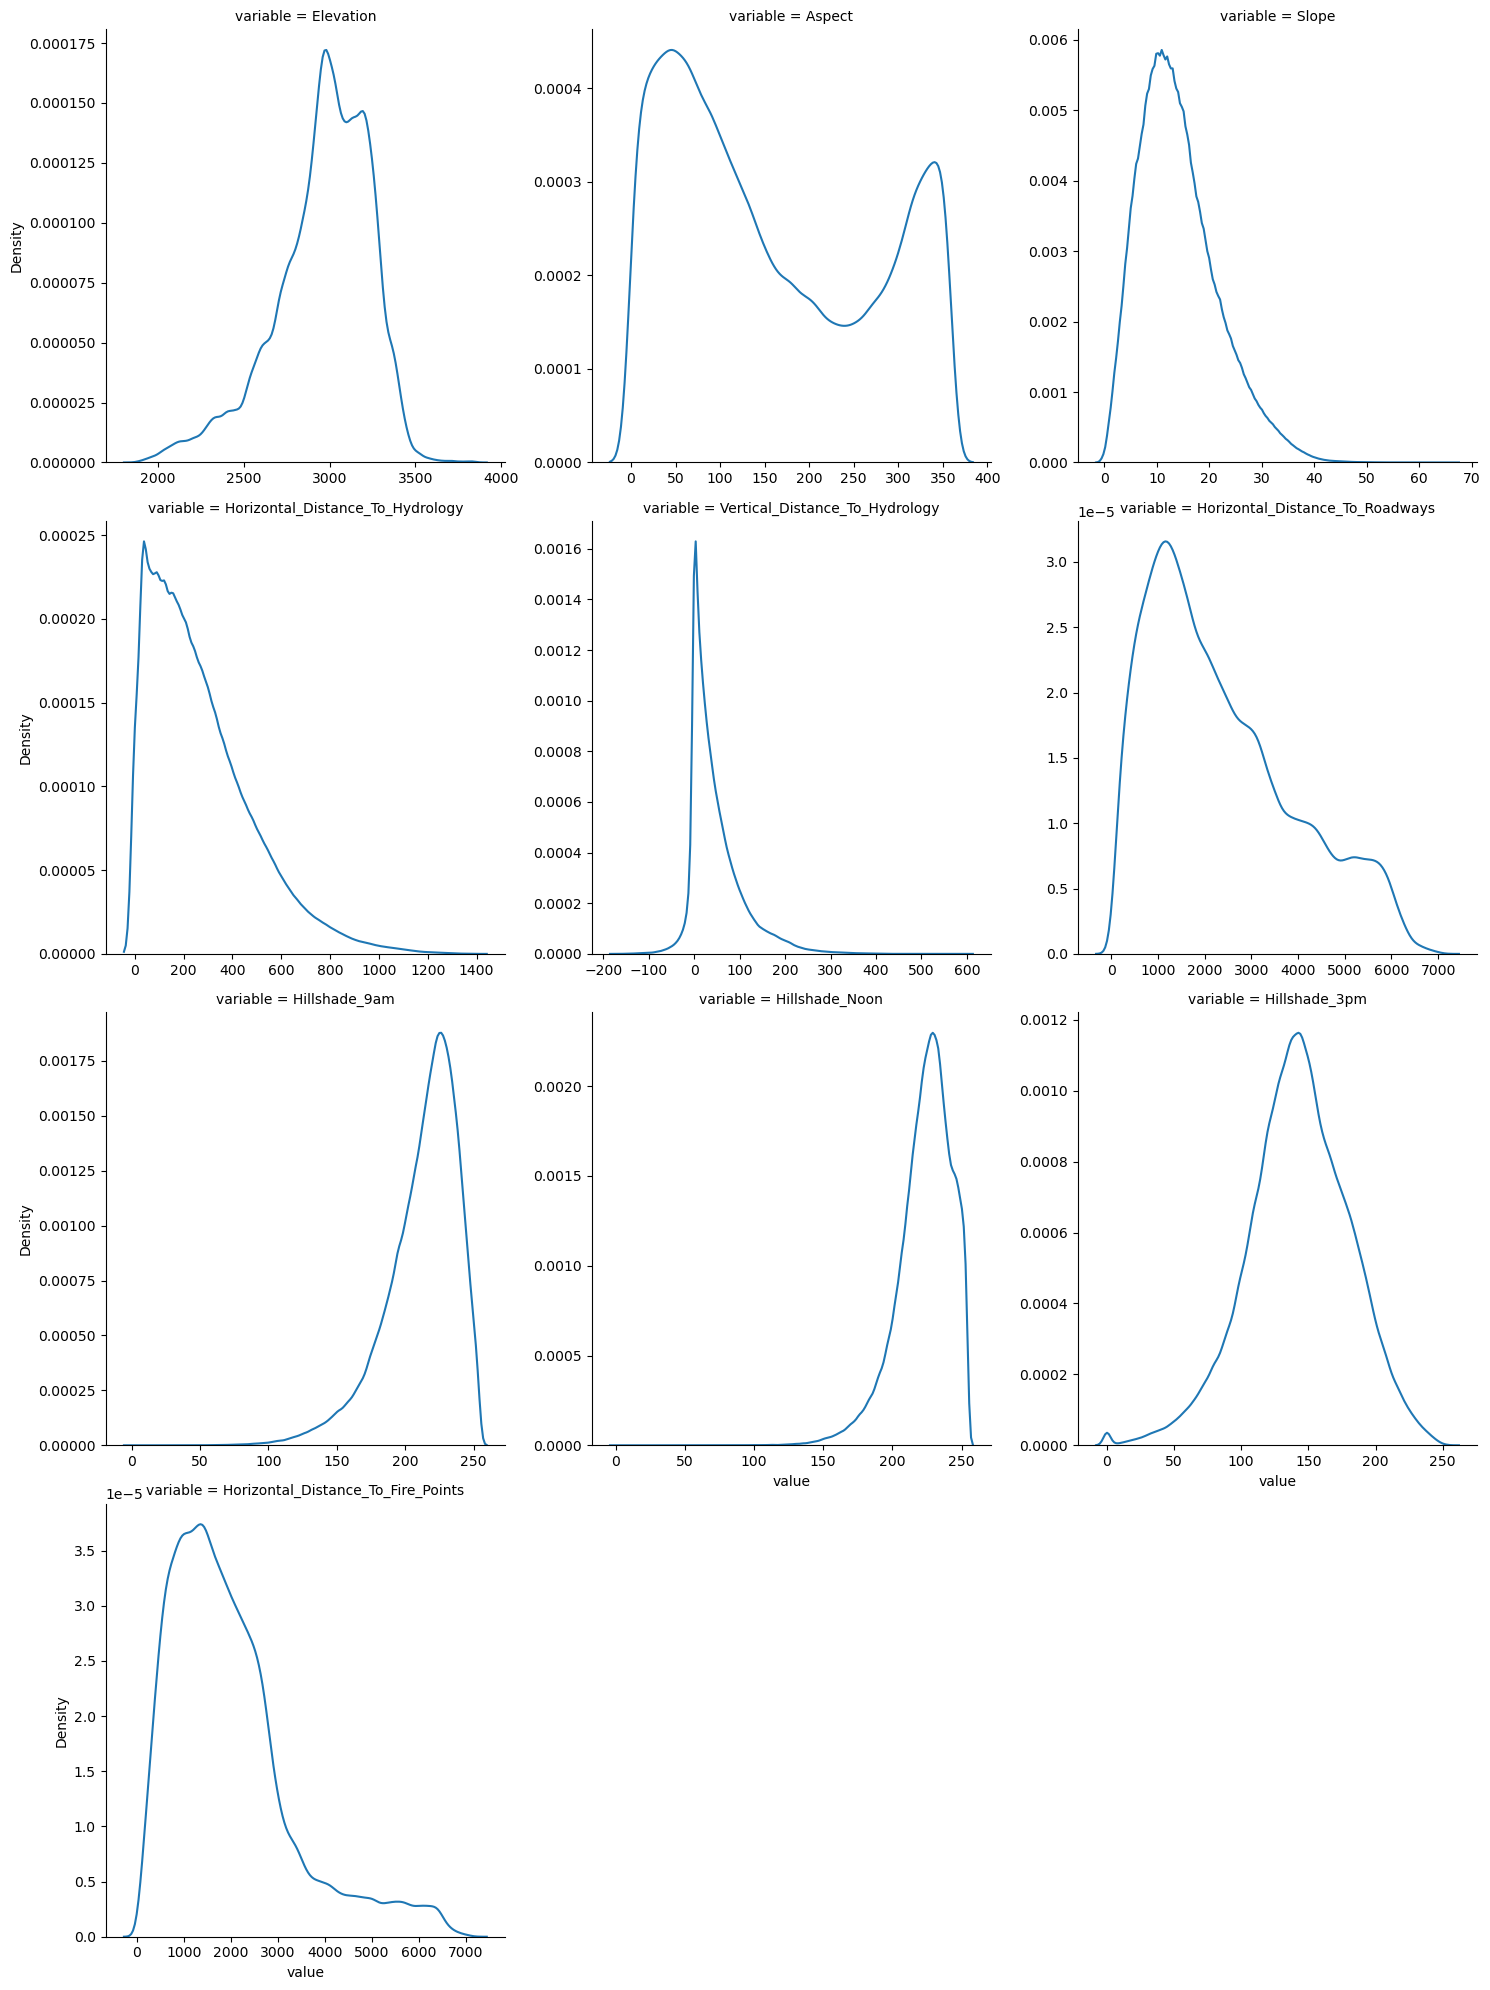

In [19]:
sns.displot(
    data=tb_melt,
    x="value",
    col="variable",
    kind="kde",
    col_wrap=3,
    facet_kws={"sharex": False, "sharey": False},
)


Poderíamos fazer a conversão de variáveis manualmente e inicializar nossos normalizadores, PCAs, Encoders separadamente. Mas o `sklearn` nos permite criar um pipeline de transformação de dados, que pode ser aplicado em qualquer conjunto de dados. Vamos criar um pipeline para transformar nossos dados e aplicá-lo em nosso dataset.

## Utilizando Pipelines

Pipelines são uma forma de automatizar o processo de transformação de dados. Eles são especialmente úteis quando temos muitas transformações a serem feitas, ou quando queremos aplicar a mesma transformação em vários conjuntos de dados diferentes (por exemplo, em um conjunto de treino e em um conjunto de teste).

In [21]:
num_vars = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]
cat_vars = ["Wilderness_Area", "Soil_Type"]

In [22]:
X = tb_cov[num_vars + cat_vars]
y = le.transform(tb_cov["target"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Agora, vamos desenhar o fluxo de transformações que serão executadas sobre nossas *features* de acordo com sua natureza (categórica ou contínua):

1. **Variáveis Contínuas**:
    1. Transformação Logarítmica (tratar assimetria);
    1. Normalização (etapa básica de pré-processamento);
    1. PCA (remover colinearidade)
1. **Variáveis Categóricas**:
    1. One-Hot Encoding (transformar em variáveis binárias dummies)

Vamos criar um pipeline para cada tipo de transformação e depois juntá-los em um pipeline único.

In [24]:
from sklearn.pipeline import Pipeline

Um pipeline nada mais é que **uma sequência de transformações e modelos** que são executados em sequencia. Para criar um pipeline, precisamos de uma lista de tuplas, onde cada tupla contém o nome do passo e o objeto que será executado. Por exemplo, para criar um pipeline que transforma nossas variáveis contínuas, precisamos de uma lista de tuplas com os seguintes passos:

1. `PowerTransformer()`: transformação logarítmica;
1. `StandardScaler()`: normalização;
1. `PCA()`: redução de dimensionalidade e colinearidade.

Para isso, precisamos inicilizar cada um desses objetos:

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer

pt = PowerTransformer()
sca = StandardScaler()
pca = PCA()

Agora, precisamos criar uma lista de tuplas com o nome de cada passo e o objeto que será executado:

In [26]:
lista_etapas = [("POWER_TRANS", pt), ("STD_SCALER", sca), ("PCA", pca)]
num_pipeline = Pipeline(lista_etapas)

Pronto! Vamos textar nosso `pipeline`:

In [27]:
num_pipeline.fit(X_train[num_vars])

Pipeline(steps=[('POWER_TRANS', PowerTransformer()),
                ('STD_SCALER', StandardScaler()), ('PCA', PCA())])

In [29]:
num_pipeline.transform(X_train[num_vars]).shape


(464809, 10)

Perfeito! Agora vamos criar um pipeline para nossas variáveis categóricas:

In [30]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder()
cat_pipeline = Pipeline([("ONE_HOT", ohe)])


In [31]:
cat_pipeline.fit(X_train[cat_vars])
cat_pipeline.transform(X_train[cat_vars])


<464809x44 sparse matrix of type '<class 'numpy.float64'>'
	with 929618 stored elements in Compressed Sparse Row format>

Simples! Agora vamos juntar os dois pipelines em um único pipeline. Para isso, vamos utilizar o `ColumnTransformer` - um objeto que nos permite aplicar transformações diferentes em colunas diferentes. Esse objeto recebe como argumento uma lista de uplas onde cada upla tem o nome da etapa, o objeto que será executado e uma lista de nomes de colunas que serão transformadas por essa etapa:

In [32]:
from sklearn.compose import ColumnTransformer

pipeline_preprocessamento = [
    ("NUMERICOS", num_pipeline, num_vars),
    ("CATEGORICOS", cat_pipeline, cat_vars),
]
data_prep_pipeline = ColumnTransformer(pipeline_preprocessamento)


In [33]:
data_prep_pipeline.fit(X_train)


ColumnTransformer(transformers=[('NUMERICOS',
                                 Pipeline(steps=[('POWER_TRANS',
                                                  PowerTransformer()),
                                                 ('STD_SCALER',
                                                  StandardScaler()),
                                                 ('PCA', PCA())]),
                                 ['Elevation', 'Aspect', 'Slope',
                                  'Horizontal_Distance_To_Hydrology',
                                  'Vertical_Distance_To_Hydrology',
                                  'Horizontal_Distance_To_Roadways',
                                  'Hillshade_9am', 'Hillshade_Noon',
                                  'Hillshade_3pm',
                                  'Horizontal_Distance_To_Fire_Points']),
                                ('CATEGORICOS',
                                 Pipeline(steps=[('ONE_HOT', OneHotEncoder())]),
                                 ['Wilderness_Area', 'Soil_Type'])])

In [34]:
data_prep_pipeline.transform(X_train)


<464809x54 sparse matrix of type '<class 'numpy.float64'>'
	with 5577708 stored elements in Compressed Sparse Row format>

É uma boa prática guardar todas as etapas de nosso pipeline em uma única célula, facilitando a adição, troca e remoção de etapas:

In [35]:
# Pipeline Numérico
pt = PowerTransformer()
sca = StandardScaler()
pca = PCA()
lista_etapas = [("POWER_TRANS", pt), ("STD_SCALER", sca), ("PCA", pca)]
num_pipeline = Pipeline(lista_etapas)

# Pipeline Categórico
ohe = OneHotEncoder()
cat_pipeline = Pipeline([("ONE_HOT", ohe)])

# Pipeline de Preprocessamento
pipeline_preprocessamento = [
    ("NUMERICOS", num_pipeline, num_vars),
    ("CATEGORICOS", cat_pipeline, cat_vars),
]
data_prep_pipeline = ColumnTransformer(pipeline_preprocessamento)


Além de etapas de pré-processamento, podemos adicionar modelos ao nosso pipeline. Vamos adicionar um modelo de regressão logística ao nosso pipeline, o qual usaremos como baseline de erro:

In [36]:
lm = LogisticRegression()
lm_pipeline = Pipeline([("PREP", data_prep_pipeline), ("LM", lm)])

Quando inserimos um modelo no final de nosso pipeline devemos incluir nossa variável target ao utilizar o método `.fit()`:

In [37]:
lm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('PREP',
                 ColumnTransformer(transformers=[('NUMERICOS',
                                                  Pipeline(steps=[('POWER_TRANS',
                                                                   PowerTransformer()),
                                                                  ('STD_SCALER',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Horizontal_Distance_To_Fire_Points']),
                                                 ('CATEGORICOS',
                                                  Pipeline(steps=[('ONE_HOT',
                                                                   OneHotEncoder())]),
                                                  ['Wilderness_Area',
                                                   'Soil_Type'])])),
                ('LM', LogisticRegression())])

Agora só precisamos avaliar o erro desse modelo...

## Erro Multi-Classe

Muitos das medidas de erro que vimos na última aula dependem do conceito de **Falso Positivo/Negativo** e **Verdadeiro Positivo/Negativo**. Esses conceitos são fáceis de entender quando temos apenas duas classes, mas como podemos aplicá-los em problemas com mais de duas classes?

In [38]:
y_pred_lm = lm_pipeline.predict(X_test)


In [39]:
y_pred_lm

array([6, 4, 4, ..., 4, 6, 4])

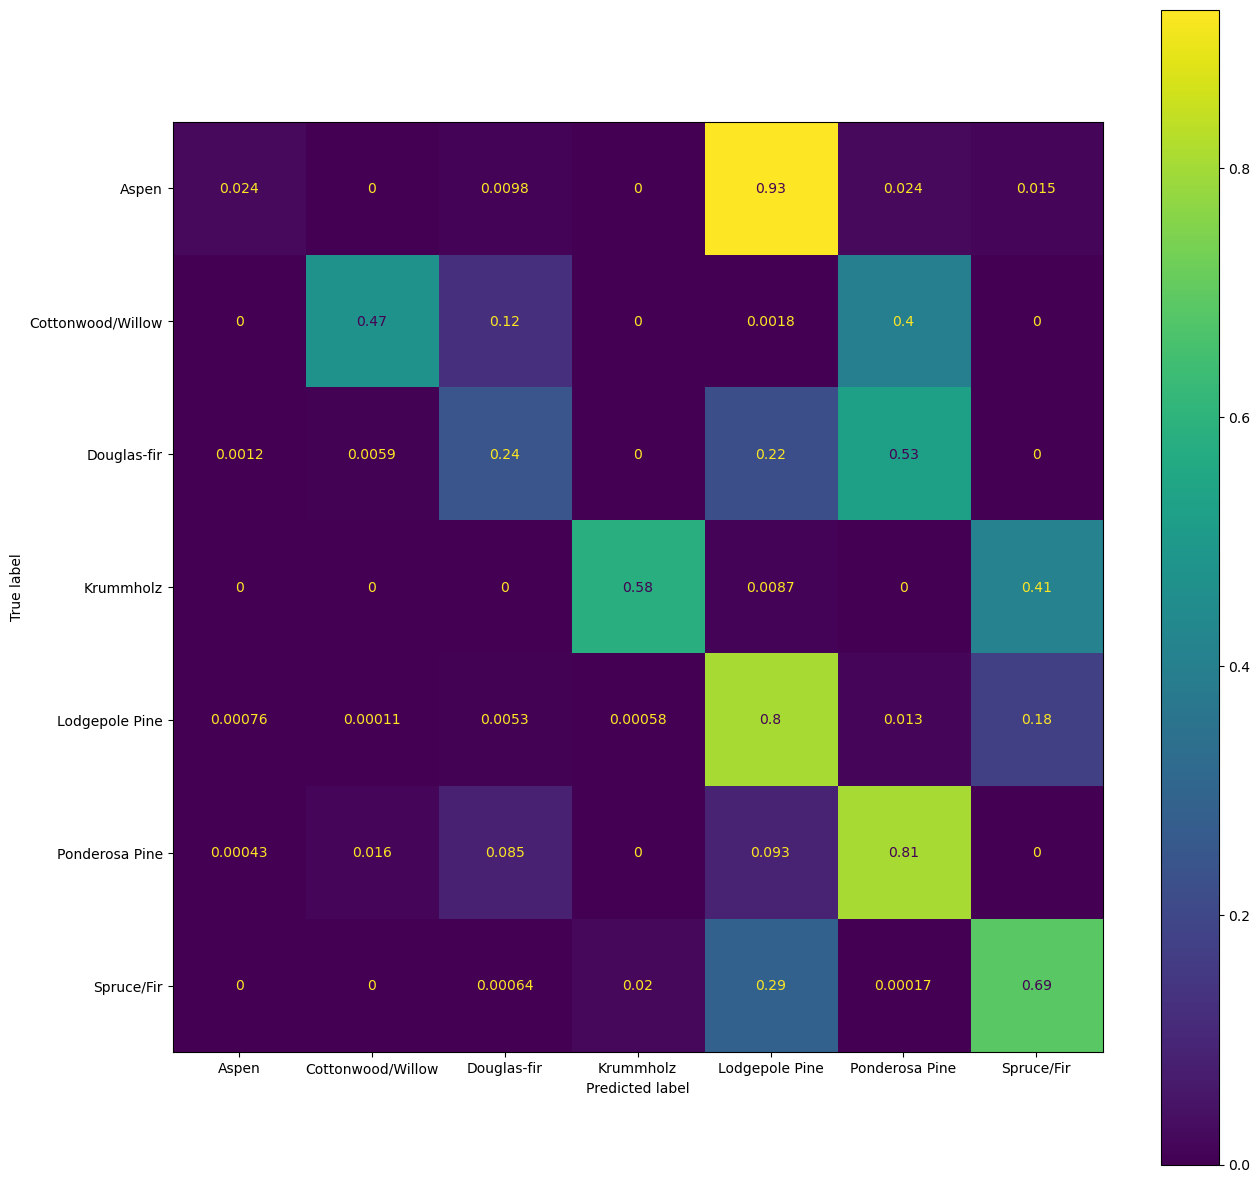

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

cf = confusion_matrix(y_test, y_pred_lm, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=le.classes_)
disp.plot(ax=ax)

Vamos entender agora como podemos calcular o erro de um modelo de classificação multi-classe.

### Acurácia (do jeito errado)

Vamos começar calculando a **acurácia média**: o número de acertos totais dividido pelo número de exemplos totais:

In [43]:
from sklearn.metrics import accuracy_score


print(f"Acurácia de {np.round(accuracy_score(y_test, y_pred_lm), 2)}")


Acurácia de 0.72


O score acima tem um problema: ele não leva em consideração o desbalanceamento de classes, nesse exemplo agravado pela natureza multi-classe do problema. Perdemos toda visibilidade que nosso modelo, em algumas classes, tem quase 100% de erro!

Esse problema ocorrerá com **todas** as funções - elas serão resultados médios, que muitas vezes podem ocultar o que está acontecendo em nosso modelo.

### Classification Report

A função `classification_report()` nos dá uma visão mais detalhada do desempenho de nosso modelo. Ela nos dá a precisão, recall e f1-score para cada classe:

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lm, target_names=le.classes_))


                   precision    recall  f1-score   support

            Aspen       0.48      0.02      0.05      1942
Cottonwood/Willow       0.66      0.47      0.55       560
      Douglas-fir       0.45      0.24      0.32      3404
        Krummholz       0.73      0.58      0.65      4028
   Lodgepole Pine       0.75      0.80      0.77     56918
   Ponderosa Pine       0.67      0.81      0.73      7033
       Spruce/Fir       0.71      0.69      0.70     42318

         accuracy                           0.72    116203
        macro avg       0.64      0.52      0.54    116203
     weighted avg       0.72      0.72      0.71    116203



Embora a visão acima seja bem detalhada, ela sofre do mesmo problema que a matriz de confusão: não conseguimos comparar de forma direta o desempenho de cada modelo. Para isso precisaremos utilizar o F1-Score (e Precision/Recall).

Nesse caso teremos o mesmo problema que na acurácia: estaremos resumindo, de alguma forma, a performance de nosso modelo à um único número. Essa simplificação é feita, tradicionalmente, de duas formas:

1. **Weighted**: calcula o F1-Score para cada classe e tira a média, ponderando esta média pelo tamanho de cada classe.
2. **Macro**: calcula o F1-Score para cada classe e tira a média, sem ponderar esta média pelo tamanho de cada classe.

Podemos ver que essas duas formas de medir o erro são antagônicas: a primeira ignora o desbalanceamento de classes, enquanto a segunda dá importância igual à todas as classes. Qual delas devemos utilizar? Depende! Se prever **classes minoritárias é importante** (previsão de eventos raros, como fraudes ou incidência de doenças raras) devemos utilizar o **F1-Score Macro**. Se **não for crítico o desempenho em classes minoritárias**, por exemplo em um modelo de categorização da busca do cliente, podemos utilizar o **F1-Score Weighted**.

In [46]:
f1_score(y_test, y_pred_lm, average="macro")


0.5378656855546395

In [47]:
print(f"Acurácia de {np.round(accuracy_score(y_test, y_pred_lm), 2)}")
print(f"F1-Score Macro de {np.round(f1_score(y_test, y_pred_lm, average='macro'), 2)}")
print(
    f"F1-Score Ponderado de {np.round(f1_score(y_test, y_pred_lm, average='weighted'), 2)}"
)

Acurácia de 0.72
F1-Score Macro de 0.54
F1-Score Ponderado de 0.71


## Interpretando nossa Regressão

In [48]:
lm_pipeline.predict_proba(X_train)

array([[4.35583118e-04, 8.60830746e-07, 6.46448228e-06, ...,
        9.11570283e-01, 4.48968243e-06, 8.79755582e-02],
       [7.81677744e-03, 3.94513694e-08, 1.05080589e-04, ...,
        7.45904065e-01, 4.12781387e-05, 2.44893697e-01],
       [1.45030979e-03, 1.96179899e-07, 1.14536119e-06, ...,
        8.39784460e-01, 6.60385157e-07, 1.58647575e-01],
       ...,
       [1.52741568e-06, 5.02560312e-17, 9.04740526e-16, ...,
        2.47346902e-03, 1.37083946e-15, 4.47500901e-01],
       [2.92518971e-03, 7.50370554e-06, 3.50029710e-06, ...,
        4.58831089e-01, 3.68661065e-07, 5.38115300e-01],
       [2.34714513e-01, 1.11890787e-03, 1.75355260e-01, ...,
        1.22234495e-01, 4.64627769e-01, 1.94668263e-03]])

In [49]:
tb_eval = X_train.copy()
probabilidades = lm_pipeline.predict_proba(X_train)
for i, tree in enumerate(le.classes_):
    tb_eval[f"prob_lm_{tree}"] = probabilidades[:,i]

In [50]:
tb_eval.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,prob_lm_Aspen,prob_lm_Cottonwood/Willow,prob_lm_Douglas-fir,prob_lm_Krummholz,prob_lm_Lodgepole Pine,prob_lm_Ponderosa Pine,prob_lm_Spruce/Fir
135326,2842.0,54.0,8.0,342.0,44.0,1956.0,225.0,222.0,130.0,1537.0,Rawah Wilderness Area,"montane, igneous and metamorphic, 44",0.000436,8.608307e-07,6.464482e-06,0.000007,0.911570,4.489682e-06,0.087976
376647,3054.0,184.0,8.0,212.0,40.0,2117.0,222.0,245.0,157.0,1465.0,Comanche Peak Wilderness Area,"subalpine, igneous and metamorphic, 56",0.007817,3.945137e-08,1.050806e-04,0.001239,0.745904,4.127814e-05,0.244894
83833,2998.0,284.0,15.0,566.0,98.0,5683.0,178.0,239.0,201.0,4277.0,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",0.001450,1.961799e-07,1.145361e-06,0.000116,0.839784,6.603852e-07,0.158648
292894,2940.0,352.0,2.0,0.0,0.0,1260.0,216.0,236.0,157.0,503.0,Comanche Peak Wilderness Area,"subalpine, glacial, 2",0.055906,7.727030e-07,2.193066e-04,0.004906,0.335445,2.302020e-05,0.603500
192006,3007.0,346.0,11.0,0.0,0.0,1691.0,199.0,223.0,162.0,1956.0,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",0.004888,1.024232e-07,7.999294e-08,0.005113,0.368922,1.466339e-08,0.621077


In [54]:
tb_eval.corr(numeric_only=True).drop(columns = X_train.select_dtypes(include = "number").columns)

,prob_lm_Aspen,prob_lm_Cottonwood/Willow,prob_lm_Douglas-fir,prob_lm_Krummholz,prob_lm_Lodgepole Pine,prob_lm_Ponderosa Pine,prob_lm_Spruce/Fir
Elevation,-0.253731,-0.269000,-0.620073,0.381573,-0.216699,-0.663928,0.754908
Aspect,-0.059300,-0.019518,0.069603,-0.007784,-0.051753,0.062980,0.006328
Slope,0.135657,0.065365,0.223342,0.002976,-0.118811,0.289665,-0.162788
Horizontal_Distance_To_Hydrology,-0.102628,-0.086704,-0.161795,0.108125,0.076532,-0.094154,0.010359
Vertical_Distance_To_Hydrology,0.029040,-0.009322,-0.001897,0.108266,-0.015630,0.089458,-0.092055
Horizontal_Distance_To_Roadways,-0.263280,-0.097398,-0.263805,0.065237,0.057595,-0.297248,0.236552
Hillshade_9am,0.166980,0.065125,-0.243302,0.047768,0.100889,-0.118935,-0.006183
Hillshade_Noon,-0.084523,-0.037958,-0.225827,-0.023935,0.160786,-0.117943,0.007865
Hillshade_3pm,-0.214646,-0.090157,0.047947,-0.053315,0.019340,-0.018080,0.043569
Horizontal_Distance_To_Fire_Points,-0.108681,-0.091845,-0.222809,0.017566,0.239987,-0.266991,0.011841


<Axes: >

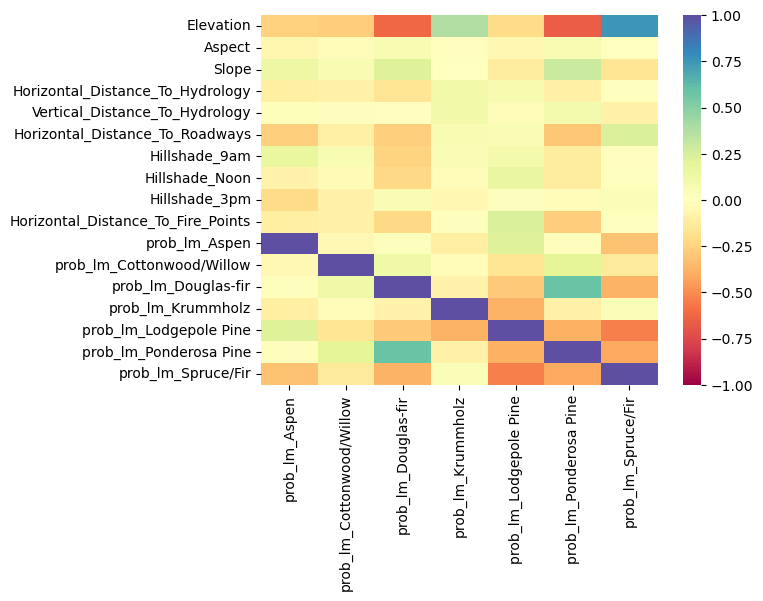

In [55]:
sns.heatmap(
    tb_eval.corr(numeric_only=True).drop(columns = X_train.select_dtypes(include = "number").columns),
    vmin = -1, vmax = 1, center = 0, cmap = "Spectral"
)

<Axes: xlabel='Elevation', ylabel='prob_lm_Spruce/Fir'>

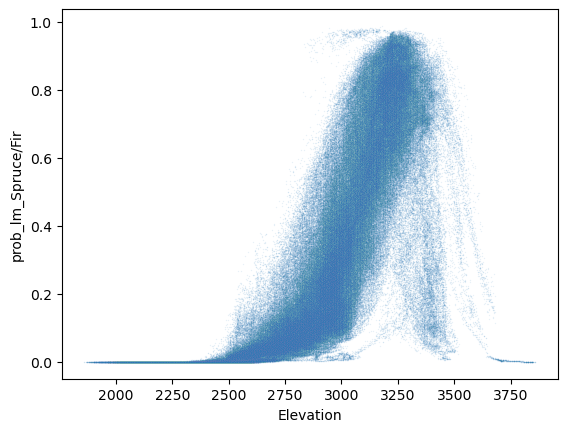

In [56]:
sns.scatterplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_lm_Spruce/Fir",
    s= 1, alpha = 0.1
)

Como nosso modelo tem muitas variáveis, embora exista uma relação clara entre a elevação e a probabilidade da cobertura ser de pinheiros-alemães, não conseguimos visualizar diretamente essa relação. Vamos construir uma base de dados específica para analisar o efeito marginal desta variável.

In [57]:
tb_eval = pd.DataFrame()
tb_eval["Elevation"] = np.linspace(X_train["Elevation"].min(), X_train["Elevation"].max(), 1000)

for column in X_train.select_dtypes(include="number").columns:
    if column != "Elevation":
        tb_eval[column] = X_train[column].mean()
        
for column in X_train.select_dtypes(exclude="number").columns:
    tb_eval[column] = X_train[column].mode()[0]
    
tb_eval.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
0,1859.000000,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
1,1861.001001,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
2,1863.002002,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
3,1865.003003,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"
4,1867.004004,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45"


In [58]:
probabilidades = lm_pipeline.predict_proba(tb_eval)
for i, tree in enumerate(le.classes_):
    tb_eval[f"prob_lm_{tree}"] = probabilidades[:,i]

In [59]:
tb_eval

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,prob_lm_Aspen,prob_lm_Cottonwood/Willow,prob_lm_Douglas-fir,prob_lm_Krummholz,prob_lm_Lodgepole Pine,prob_lm_Ponderosa Pine,prob_lm_Spruce/Fir
0,1859.000000,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",3.118520e-02,7.917304e-02,3.193362e-01,1.118483e-09,2.244327e-01,3.454301e-01,0.000443
1,1861.001001,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",3.140212e-02,7.893159e-02,3.184036e-01,1.139734e-09,2.265040e-01,3.443099e-01,0.000449
2,1863.002002,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",3.162033e-02,7.868797e-02,3.174620e-01,1.161421e-09,2.285944e-01,3.431804e-01,0.000455
3,1865.003003,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",3.183981e-02,7.844215e-02,3.165115e-01,1.183555e-09,2.307039e-01,3.420416e-01,0.000461
4,1867.004004,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",3.206056e-02,7.819414e-02,3.155520e-01,1.206144e-09,2.328325e-01,3.408935e-01,0.000467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3849.995996,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",7.299435e-12,4.585603e-27,2.946894e-26,9.982318e-01,1.756826e-07,9.956440e-27,0.001768
996,3851.996997,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",6.672790e-12,3.887301e-27,2.500581e-26,9.983017e-01,1.633602e-07,8.427901e-27,0.001698
997,3853.997998,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",6.099134e-12,3.294541e-27,2.121353e-26,9.983689e-01,1.518858e-07,7.132290e-27,0.001631
998,3855.998999,155.644387,14.104411,269.411221,46.427754,2349.549983,212.144365,223.306018,142.512765,1980.22344,Rawah Wilderness Area,"subalpine, igneous and metamorphic, 45",5.574056e-12,2.791495e-27,1.799206e-26,9.984335e-01,1.412021e-07,6.034381e-27,0.001566


<Axes: xlabel='Elevation', ylabel='prob_lm_Spruce/Fir'>

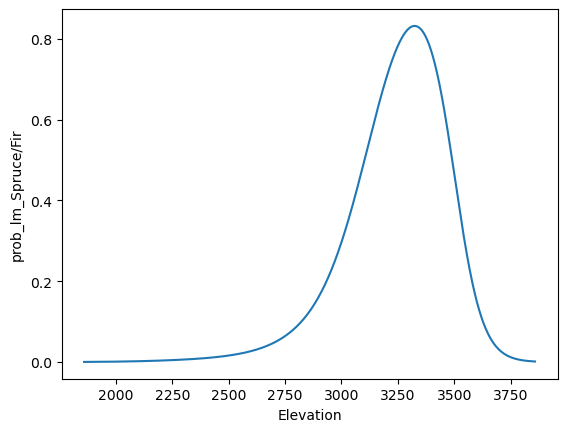

In [60]:
sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_lm_Spruce/Fir"
)

# Redes Neurais

Redes neurais são uma classe de modelo preditivo que surgiu a partir da pesquisa sobre o funcionamento das células neuronais do cérebro - desenvolvida inicialmente por McCulloh e Pitts na década de 40. O modelo mais comum de rede neural, o **perceptron de múltiplas camadas (MLP)** foi desenvolvido em 1958 pelo psicológo Rosenblatt.

Os **MLPs** são caracterizados por dois atributos fundamentais:

* Número de neurônios por camada;
* Função de Ativação.

![MLP](images/multipercep.jpg)

Vamos criar um MLP para resolver nosso problema de classificação, variando o tamanho de nossa rede neural e analisando o resultado de nossas previsões:

In [61]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(3, 3), activation="relu", random_state=10)
mlp_pipeline = Pipeline([("PREP", data_prep_pipeline), ("MLP", mlp)])

In [62]:
mlp_pipeline.fit(X_train, y_train)


Pipeline(steps=[('PREP',
                 ColumnTransformer(transformers=[('NUMERICOS',
                                                  Pipeline(steps=[('POWER_TRANS',
                                                                   PowerTransformer()),
                                                                  ('STD_SCALER',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Horizontal_Distance_To_Fire_Points']),
                                                 ('CATEGORICOS',
                                                  Pipeline(steps=[('ONE_HOT',
                                                                   OneHotEncoder())]),
                                                  ['Wilderness_Area',
                                                   'Soil_Type'])])),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(3, 3), random_state=10))])

Agora, vamos avaliar nosso modelo:

In [63]:
y_pred_nn = mlp_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_nn, target_names=le.classes_))

                   precision    recall  f1-score   support

            Aspen       0.00      0.00      0.00      1942
Cottonwood/Willow       1.00      0.00      0.00       560
      Douglas-fir       0.35      0.03      0.06      3404
        Krummholz       0.72      0.59      0.65      4028
   Lodgepole Pine       0.75      0.80      0.78     56918
   Ponderosa Pine       0.62      0.85      0.72      7033
       Spruce/Fir       0.71      0.71      0.71     42318

         accuracy                           0.72    116203
        macro avg       0.59      0.43      0.42    116203
     weighted avg       0.71      0.72      0.71    116203



Vamos nos lembrar dos resultados da regressão:

In [64]:
print(classification_report(y_test, y_pred_lm, target_names=le.classes_))

                   precision    recall  f1-score   support

            Aspen       0.48      0.02      0.05      1942
Cottonwood/Willow       0.66      0.47      0.55       560
      Douglas-fir       0.45      0.24      0.32      3404
        Krummholz       0.73      0.58      0.65      4028
   Lodgepole Pine       0.75      0.80      0.77     56918
   Ponderosa Pine       0.67      0.81      0.73      7033
       Spruce/Fir       0.71      0.69      0.70     42318

         accuracy                           0.72    116203
        macro avg       0.64      0.52      0.54    116203
     weighted avg       0.72      0.72      0.71    116203



<Axes: xlabel='Elevation', ylabel='prob_nn_Spruce/Fir'>

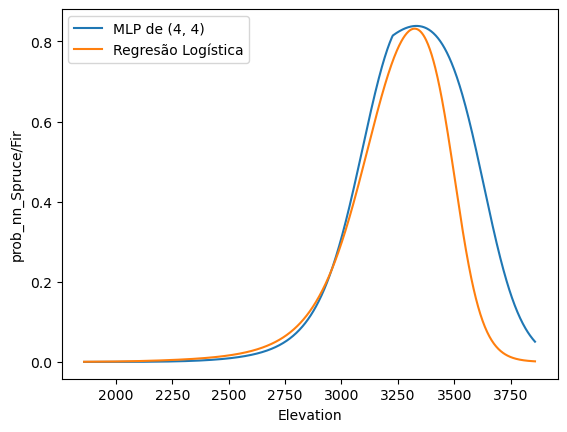

In [65]:
probabilidades = mlp_pipeline.predict_proba(tb_eval)
for i, tree in enumerate(le.classes_):
    tb_eval[f"prob_nn_{tree}"] = probabilidades[:,i]
    
sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_nn_Spruce/Fir",
    label = "MLP de (4, 4)"
)

sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_lm_Spruce/Fir",
    label = "Regresão Logística"
)

Como podemos ver, pelo menos neste efeito, uma rede neural simples se comporta de maneira bem semelhante à nossa regressão. Vamos aumentar o número de neurônios em nossa rede neural e ver o que acontece:

54 * 30 = 1500
30 * 30 = 900
30 * 30 = 900
30 * 7 = 210

3500 conexões (alphas) <<< # de linhas

In [66]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation="relu", random_state=10)
mlp_pipeline = Pipeline([("PREP", data_prep_pipeline), ("MLP", mlp)])
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('PREP',
                 ColumnTransformer(transformers=[('NUMERICOS',
                                                  Pipeline(steps=[('POWER_TRANS',
                                                                   PowerTransformer()),
                                                                  ('STD_SCALER',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Horizontal_Distance_To_Fire_Points']),
                                                 ('CATEGORICOS',
                                                  Pipeline(steps=[('ONE_HOT',
                                                                   OneHotEncoder())]),
                                                  ['Wilderness_Area',
                                                   'Soil_Type'])])),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(30, 30, 30),
                               random_state=10))])

<Axes: xlabel='Elevation', ylabel='prob_nn_Spruce/Fir'>

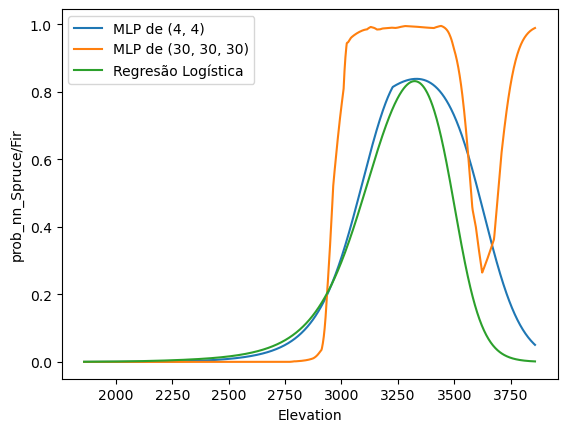

In [67]:
probabilidades = mlp_pipeline.predict_proba(tb_eval)
for i, tree in enumerate(le.classes_):
    tb_eval[f"prob_nn2_{tree}"] = probabilidades[:,i]
    
sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_nn_Spruce/Fir",
    label = "MLP de (4, 4)"
)

sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_nn2_Spruce/Fir",
    label = "MLP de (30, 30, 30)"
)

sns.lineplot(
    data = tb_eval,
    x = "Elevation",
    y = "prob_lm_Spruce/Fir",
    label = "Regresão Logística"
)

Claramente a rede complexa é muito menos linear que nossos dois outros modelos! Vamos avaliar o erro de nosso modelo:

In [68]:
y_pred_nn2 = mlp_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_nn2, target_names=le.classes_))

                   precision    recall  f1-score   support

            Aspen       0.79      0.63      0.70      1942
Cottonwood/Willow       0.91      0.70      0.79       560
      Douglas-fir       0.78      0.76      0.77      3404
        Krummholz       0.93      0.86      0.89      4028
   Lodgepole Pine       0.89      0.91      0.90     56918
   Ponderosa Pine       0.85      0.90      0.87      7033
       Spruce/Fir       0.88      0.86      0.87     42318

         accuracy                           0.88    116203
        macro avg       0.86      0.80      0.83    116203
     weighted avg       0.88      0.88      0.88    116203



Uma melhoria significativa - especialmente nas classes minoritárias! Como todos os algoritmos de ML, redes neurais tem muitos hiperparâmetros que podem ser ajustados para melhorar o desempenho do modelo. Os principais são:

1. **Topologia da rede** - `hidden_layer_sizes`: número de camadas e número de neurônios por camada (em um MLP);
1. **Função de Ativação** - `activation`: função que determina o valor de saída de cada neurônio (hoje em dia quase nunca utilizamos funções diferentes da **ReLU**);
1. **Taxa de Aprendizagem** - `learning_rate_init`: o *learning rate* determina o quão agressiva a rede neural tenta se ajustar aos dados em cada iteração do algoritmo de otimização, padrão entre 0.00001 e 1;
1. **Número de Iterações** - `max_iter`: número de iterações do algoritmo de otimização (quantas vezes seu dataset completo passa pela rede).

Vamos ver como podemos alterar o `max_iter` buscando um ponto ótimo entre precisão e tempo de treinamento:

In [69]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation="relu", random_state=10, max_iter = 10)
mlp_pipeline = Pipeline([("PREP", data_prep_pipeline), ("MLP", mlp)])
mlp_pipeline.fit(X_train, y_train)
y_pred_nn2 = mlp_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_nn2, target_names=le.classes_))

                   precision    recall  f1-score   support

            Aspen       0.75      0.44      0.56      1942
Cottonwood/Willow       0.90      0.55      0.68       560
      Douglas-fir       0.72      0.45      0.55      3404
        Krummholz       0.92      0.74      0.82      4028
   Lodgepole Pine       0.82      0.91      0.87     56918
   Ponderosa Pine       0.78      0.85      0.81      7033
       Spruce/Fir       0.86      0.78      0.82     42318

         accuracy                           0.83    116203
        macro avg       0.82      0.68      0.73    116203
     weighted avg       0.83      0.83      0.83    116203



In [ ]:
f1_list = []
for i in range(5, 101, 10):
    mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), activation="relu", random_state=10, max_iter = i)
    mlp_pipeline = Pipeline([("PREP", data_prep_pipeline), ("MLP", mlp)])
    mlp_pipeline.fit(X_train, y_train)
    y_pred_test = mlp_pipeline.predict(X_test)
    y_pred_train = mlp_pipeline.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average="macro")
    f1_test = f1_score(y_test, y_pred_test, average="macro")
    f1_list.append([i, f1_train, f1_test])

In [ ]:
tb_f1 = pd.DataFrame(f1_list, columns = ["max_iter", "f1_train", "f1_test"])
sns.lineplot(data = tb_f1, x = "max_iter", y = "f1_train", label = "Treino")
sns.lineplot(data = tb_f1, x = "max_iter", y = "f1_test", label = "Teste")

# Voltamos 21h34!